# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

=== INFORMACIÓN GENERAL DEL DATASET ===
Forma del dataset: (10495, 10)
Columnas: ['Price', 'Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
Tipos de datos:
Price          int64
Year           int64
Mileage        int64
M_Camry         bool
M_Camry4dr      bool
M_CamryBase     bool
M_CamryL        bool
M_CamryLE       bool
M_CamrySE       bool
M_CamryXLE      bool
dtype: object

=== ESTADÍSTICAS DESCRIPTIVAS ===
              Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000000   2016.000000   71355.500000
max    32444.000000   2018.000000  232658.000000

=== VALORES NULOS ===
Price          0
Year           0
Mileage        0
M_Camry 

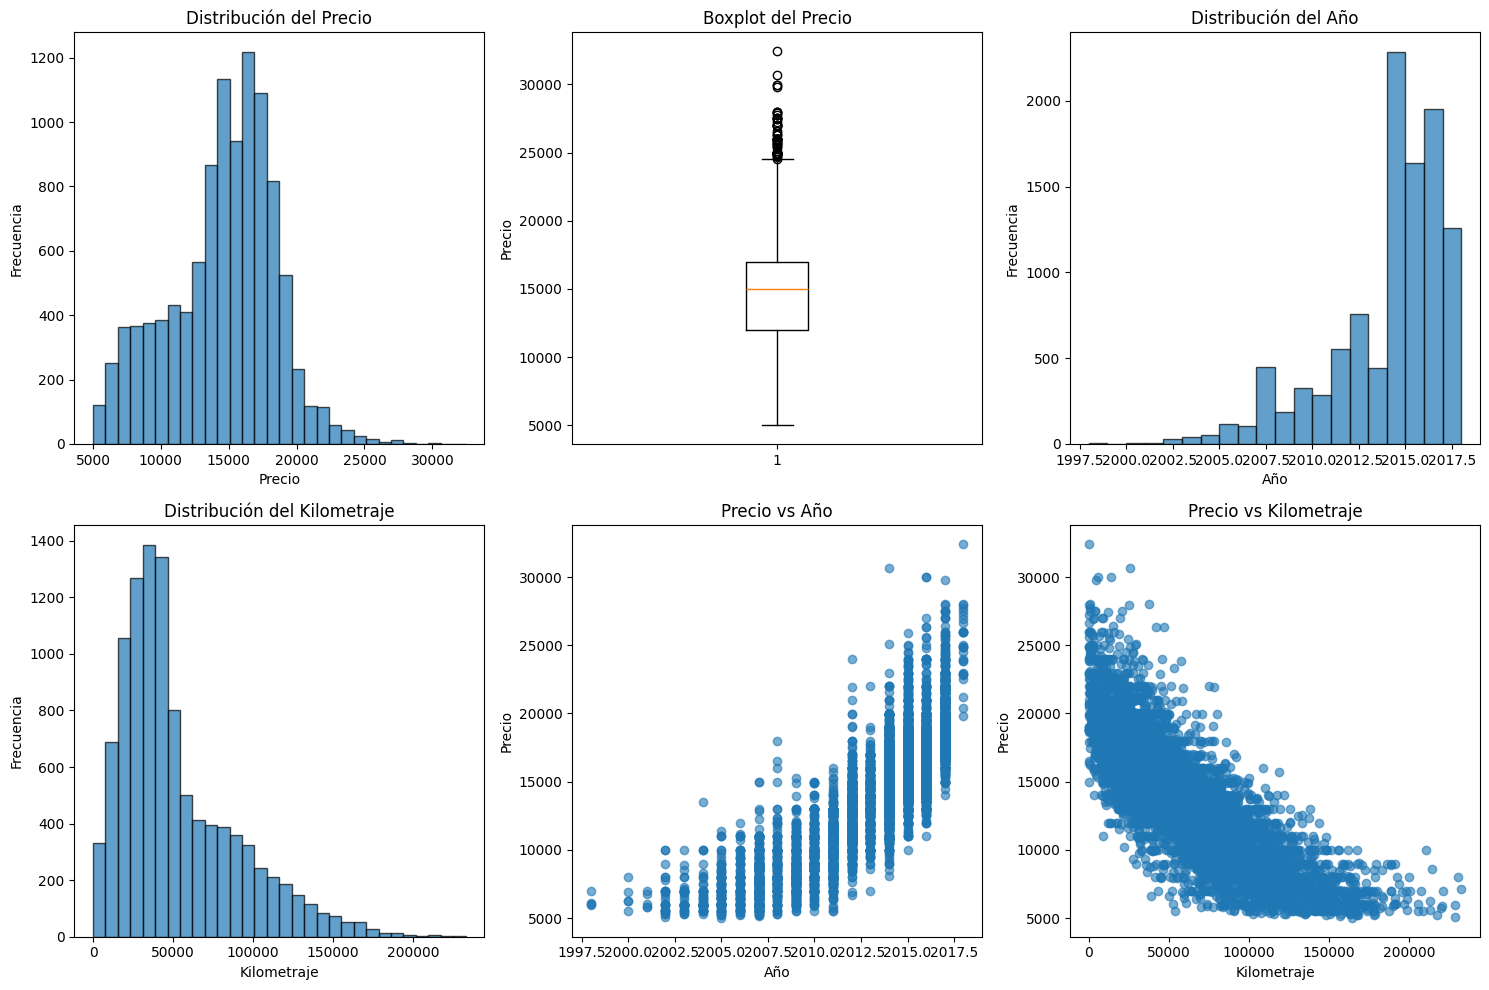


=== MATRIZ DE CORRELACIÓN ===


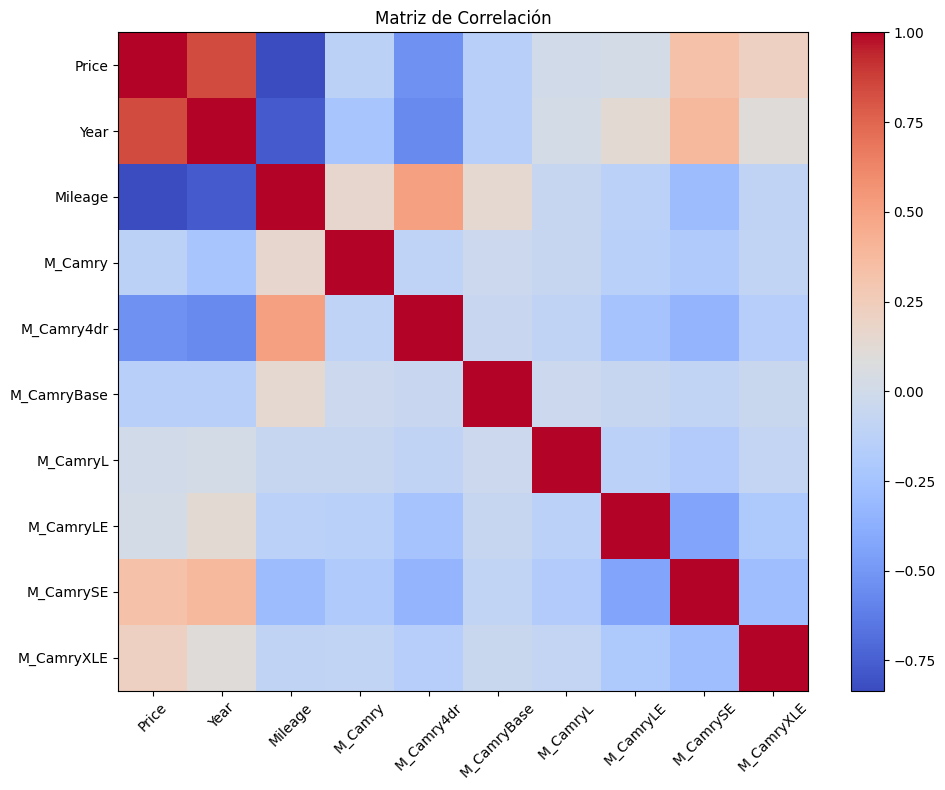

Correlaciones con el Precio:
Price          1.000000
Year           0.842194
M_CamrySE      0.327458
M_CamryXLE     0.214611
M_CamryLE      0.023929
M_CamryL       0.008389
M_Camry       -0.119099
M_CamryBase   -0.152627
M_Camry4dr    -0.531215
Mileage       -0.833761
Name: Price, dtype: float64

=== RESUMEN DEL ANÁLISIS ===
- Dataset con 10495 filas y 10 columnas
- Variable objetivo: Price (rango: $5,002 - $32,444)
- Variables predictoras principales: Year, Mileage, y variables dummy de Model
- No hay valores nulos después de la limpieza
- Correlación más fuerte con Price: Year (0.842)


In [ ]:
# Celda 0 - Exploración y análisis de datos

# 1. Información general del dataset
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Forma del dataset: {data.shape}")
print(f"Columnas: {list(data.columns)}")
print(f"Tipos de datos:\n{data.dtypes}")

# 2. Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(data.describe())

# 3. Verificar valores nulos
print("\n=== VALORES NULOS ===")
print(data.isnull().sum())

# 4. Verificar valores duplicados
print(f"\nFilas duplicadas: {data.duplicated().sum()}")

# 5. Imputación de valores nulos (si los hay)
if data.isnull().sum().sum() > 0:
    print("\n=== IMPUTANDO VALORES NULOS ===")
    # Para variables numéricas usar la mediana
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if data[col].isnull().sum() > 0:
            data[col].fillna(data[col].median(), inplace=True)
            print(f"Imputados {col} con la mediana")

# 6. Exploración visual
print("\n=== EXPLORACIÓN VISUAL ===")

# Distribución de la variable objetivo (Price)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(data['Price'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribución del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Boxplot del precio
plt.subplot(2, 3, 2)
plt.boxplot(data['Price'])
plt.title('Boxplot del Precio')
plt.ylabel('Precio')

# Distribución del año
plt.subplot(2, 3, 3)
plt.hist(data['Year'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribución del Año')
plt.xlabel('Año')
plt.ylabel('Frecuencia')

# Distribución del kilometraje
plt.subplot(2, 3, 4)
plt.hist(data['Mileage'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribución del Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Frecuencia')

# Relación Precio vs Año
plt.subplot(2, 3, 5)
plt.scatter(data['Year'], data['Price'], alpha=0.6)
plt.title('Precio vs Año')
plt.xlabel('Año')
plt.ylabel('Precio')

# Relación Precio vs Kilometraje
plt.subplot(2, 3, 6)
plt.scatter(data['Mileage'], data['Price'], alpha=0.6)
plt.title('Precio vs Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Precio')

plt.tight_layout()
plt.show()

# 7. Matriz de correlación
print("\n=== MATRIZ DE CORRELACIÓN ===")
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Matriz de Correlación')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()

# 8. Correlaciones con la variable objetivo
print("Correlaciones con el Precio:")
correlations = data.corr()['Price'].sort_values(ascending=False)
print(correlations)

# 9. Resumen del análisis
print("\n=== RESUMEN DEL ANÁLISIS ===")
print(f"- Dataset con {data.shape[0]} filas y {data.shape[1]} columnas")
print(f"- Variable objetivo: Price (rango: ${data['Price'].min():,.0f} - ${data['Price'].max():,.0f})")
print(f"- Variables predictoras principales: Year, Mileage, y variables dummy de Model")
print(f"- No hay valores nulos después de la limpieza")
print(f"- Correlación más fuerte con Price: {correlations.index[1]} ({correlations.iloc[1]:.3f})")


### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

=== MÉTRICAS DEL MODELO ===
R² Entrenamiento: 0.972
R² Prueba: 0.796
RMSE Prueba: $1,765


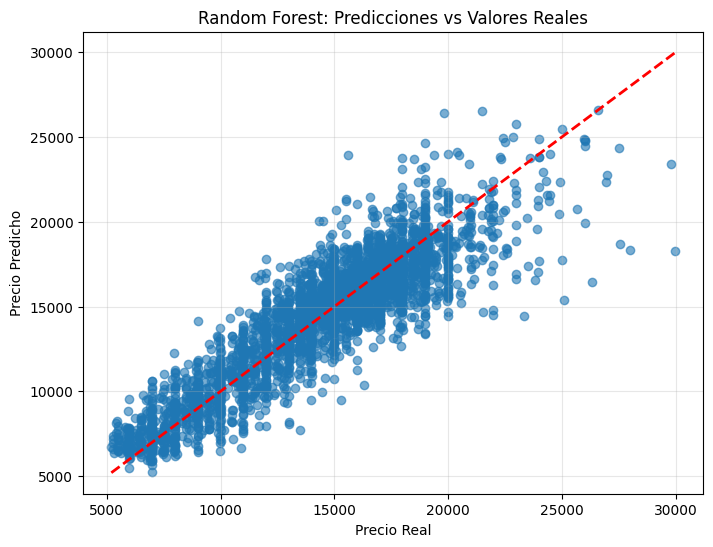


=== COMENTARIOS SOBRE EL DESEMPEÑO ===
El modelo explica el 79.6% de la variabilidad en los precios de prueba.
✓ Buen desempeño (R² > 0.6)
⚠ Posible sobreajuste detectado (diferencia: 0.176)

Error promedio de predicción: $1,765


In [ ]:
# Celda 1

rf_model = RandomForestRegressor(random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Evaluar desempeño
print("=== MÉTRICAS DEL MODELO ===")
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² Entrenamiento: {r2_train:.3f}")
print(f"R² Prueba: {r2_test:.3f}")
print(f"RMSE Prueba: ${rmse_test:,.0f}")

# Gráfico 
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Random Forest: Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)
plt.show()

# Comentarios sobre desempeño
print("\n=== COMENTARIOS SOBRE EL DESEMPEÑO ===")
print(f"El modelo explica el {r2_test*100:.1f}% de la variabilidad en los precios de prueba.")

if r2_test > 0.8:
    print("✓ Excelente desempeño (R² > 0.8)")
elif r2_test > 0.6:
    print("✓ Buen desempeño (R² > 0.6)")
else:
    print("⚠ Desempeño moderado, se puede mejorar")

# Verificar sobreajuste
diferencia = r2_train - r2_test
if diferencia > 0.1:
    print(f"⚠ Posible sobreajuste detectado (diferencia: {diferencia:.3f})")
else:
    print("✓ No hay evidencia de sobreajuste significativo")

print(f"\nError promedio de predicción: ${rmse_test:,.0f}")

### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 2

print("=== CALIBRANDO PARÁMETROS RANDOM FOREST ===")
print("Buscando los mejores valores para mejorar el modelo...\n")

# Definir los parámetros que vamos a probar (valores simples)
parametros = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [5, 10, None],               # Profundidad máxima
    'max_features': ['sqrt', 'log2']          # Número de características por árbol
}

print("Parámetros que vamos a probar:")
print("• n_estimators (número de árboles):", parametros['n_estimators'])
print("• max_depth (profundidad):", parametros['max_depth'])  
print("• max_features (características por árbol):", parametros['max_features'])
print("\nEsto puede tomar unos minutos...")

# Buscar los mejores parámetros
from sklearn.model_selection import GridSearchCV

rf_busqueda = GridSearchCV(
    RandomForestRegressor(random_state=42),
    parametros,
    cv=3,                    # Validación cruzada de 3 partes
    scoring='r2',            # Usar R² como métrica
    n_jobs=-1               # Usar todos los procesadores
)

# Entrenar con diferentes combinaciones
rf_busqueda.fit(X_train, y_train)

print("\n=== RESULTADOS ===")
print("Mejores parámetros encontrados:")
print(rf_busqueda.best_params_)
print(f"Mejor puntuación R²: {rf_busqueda.best_score_:.3f}")



=== CALIBRANDO PARÁMETROS RANDOM FOREST ===
Buscando los mejores valores para mejorar el modelo...

Parámetros que vamos a probar:
• n_estimators (número de árboles): [50, 100, 200]
• max_depth (profundidad): [5, 10, None]
• max_features (características por árbol): ['sqrt', 'log2']

Esto puede tomar unos minutos...

=== RESULTADOS ===
Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuación R²: 0.846

=== RESULTADOS ===
Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuación R²: 0.846

=== RESULTADOS ===
Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuación R²: 0.846


=== COMPARACIÓN DE MODELOS ===
Modelo BÁSICO:
  - R²: 0.796
  - RMSE: $1,765

Modelo MEJORADO:
  - R²: 0.840
  - RMSE: $1,564

🎯 MEJORAS OBTENIDAS:
  - Mejora en R²: +0.044
  - Reducción en RMSE: $201


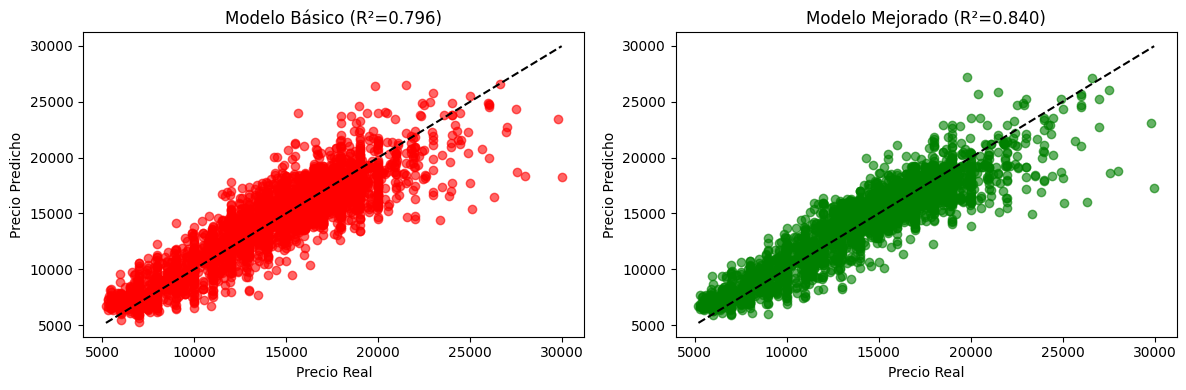


=== CÓMO AFECTAN LOS PARÁMETROS ===
🌳 n_estimators (número de árboles):
   - MÁS árboles = mejor precisión pero más lento
   - MENOS árboles = más rápido pero menos preciso

📏 max_depth (profundidad):
   - Profundidad alta = puede memorizar datos (sobreajuste)
   - Profundidad baja = modelo más simple y general
   - None = sin límite (cuidado con sobreajuste)

🎯 max_features (características por árbol):
   - 'sqrt' = usa raíz cuadrada del total (reduce sobreajuste)
   - 'log2' = usa log base 2 del total (más diversidad)
   - Menos características = más diversidad entre árboles


In [ ]:
# Encontrar los mejores hiperparámetros y entrenar el modelo mejorado

# Obtener el mejor modelo
mejor_modelo = rf_busqueda.best_estimator_

# Hacer predicciones con el modelo mejorado
y_pred_mejorado = mejor_modelo.predict(X_test)

# Comparar con el modelo básico
print("=== COMPARACIÓN DE MODELOS ===")
r2_mejorado = r2_score(y_test, y_pred_mejorado)
rmse_mejorado = np.sqrt(mean_squared_error(y_test, y_pred_mejorado))

print(f"Modelo BÁSICO:")
print(f"  - R²: {r2_test:.3f}")
print(f"  - RMSE: ${rmse_test:,.0f}")

print(f"\nModelo MEJORADO:")
print(f"  - R²: {r2_mejorado:.3f}")
print(f"  - RMSE: ${rmse_mejorado:,.0f}")

# Calcular la mejora
mejora_r2 = r2_mejorado - r2_test
mejora_rmse = rmse_test - rmse_mejorado

print(f"\n MEJORAS OBTENIDAS:")
print(f"  - Mejora en R²: +{mejora_r2:.3f}")
print(f"  - Reducción en RMSE: ${mejora_rmse:,.0f}")

# Gráfico de comparación
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='red', label='Básico')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Modelo Básico (R²={r2_test:.3f})')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_mejorado, alpha=0.6, color='green', label='Mejorado')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Modelo Mejorado (R²={r2_mejorado:.3f})')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')

plt.tight_layout()
plt.show()

print("\n=== CÓMO AFECTAN LOS PARÁMETROS ===")
print("n_estimators (número de árboles):")
print("   - MÁS árboles = mejor precisión pero más lento")
print("   - MENOS árboles = más rápido pero menos preciso")

print("\n max_depth (profundidad):")
print("   - Profundidad alta = puede memorizar datos (sobreajuste)")
print("   - Profundidad baja = modelo más simple y general")
print("   - None = sin límite (cuidado con sobreajuste)")

print("\n max_features (características por árbol):")
print("   - 'sqrt' = usa raíz cuadrada del total (reduce sobreajuste)")
print("   - 'log2' = usa log base 2 del total (más diversidad)")
print("   - Menos características = más diversidad entre árboles")

=== IMPORTANCIA DE VARIABLES ===
(De más importante a menos importante)
      Variable  Importancia
0         Year     0.441741
1      Mileage     0.436240
3   M_Camry4dr     0.062832
7    M_CamrySE     0.020267
8   M_CamryXLE     0.019286
6    M_CamryLE     0.007529
2      M_Camry     0.007160
5     M_CamryL     0.002928
4  M_CamryBase     0.002018


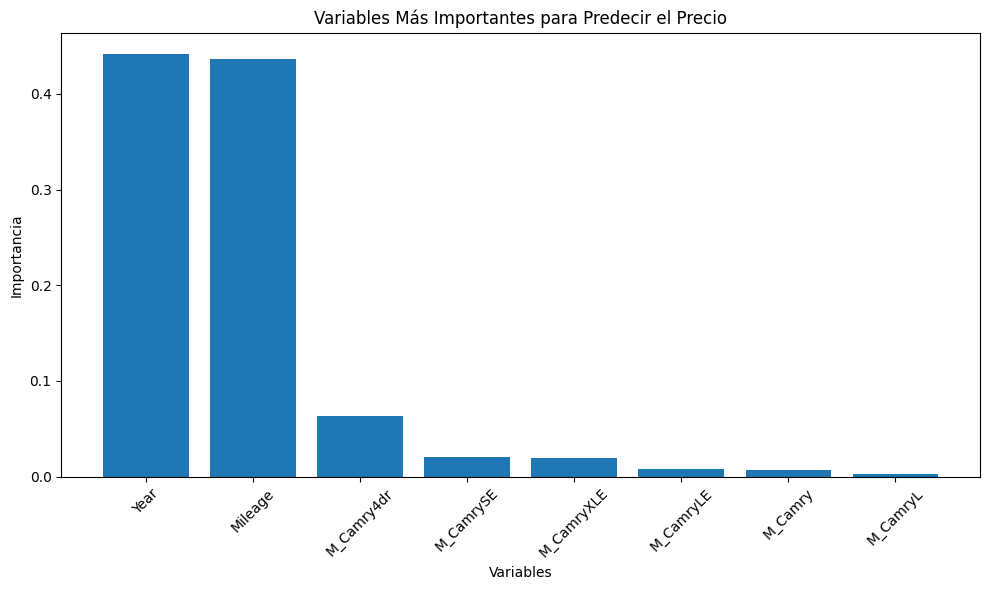


🏆 La variable MÁS importante es: Year
   Contribuye con 0.442 del poder predictivo

📊 RESUMEN:
   - El modelo usa 9 variables en total
   - Las top 3 variables explican 0.941 del modelo
   - Esto significa que unas pocas variables son muy importantes


In [ ]:
# Importancia de los predictores

# Ver qué variables son más importantes
importancias = mejor_modelo.feature_importances_
nombres_variables = X.columns

# Tabla ordenada
tabla_importancia = pd.DataFrame({
    'Variable': nombres_variables,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

print("=== IMPORTANCIA DE VARIABLES ===")
print("(De más importante a menos importante)")
print(tabla_importancia)

# Gráfico de barras simple
plt.figure(figsize=(10, 6))
plt.bar(tabla_importancia['Variable'][:8], tabla_importancia['Importancia'][:8])
plt.title('Variables Más Importantes para Predecir el Precio')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n🏆 La variable MÁS importante es: {tabla_importancia.iloc[0]['Variable']}")
print(f"   Contribuye con {tabla_importancia.iloc[0]['Importancia']:.3f} del poder predictivo")

print(f"\n RESUMEN:")
print(f"   - El modelo usa {len(nombres_variables)} variables en total")
print(f"   - Las top 3 variables explican {tabla_importancia.iloc[:3]['Importancia'].sum():.3f} del modelo")
print(f"   - Esto significa que unas pocas variables son muy importantes")

### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

=== ANÁLISIS FINAL DE RESULTADOS ===
DESEMPEÑO DEL MODELO FINAL:
• R² Score: 0.840 (84.0% de variabilidad explicada)
• RMSE: $1,564 (error promedio)
• MAE: $1,147 (error absoluto medio)


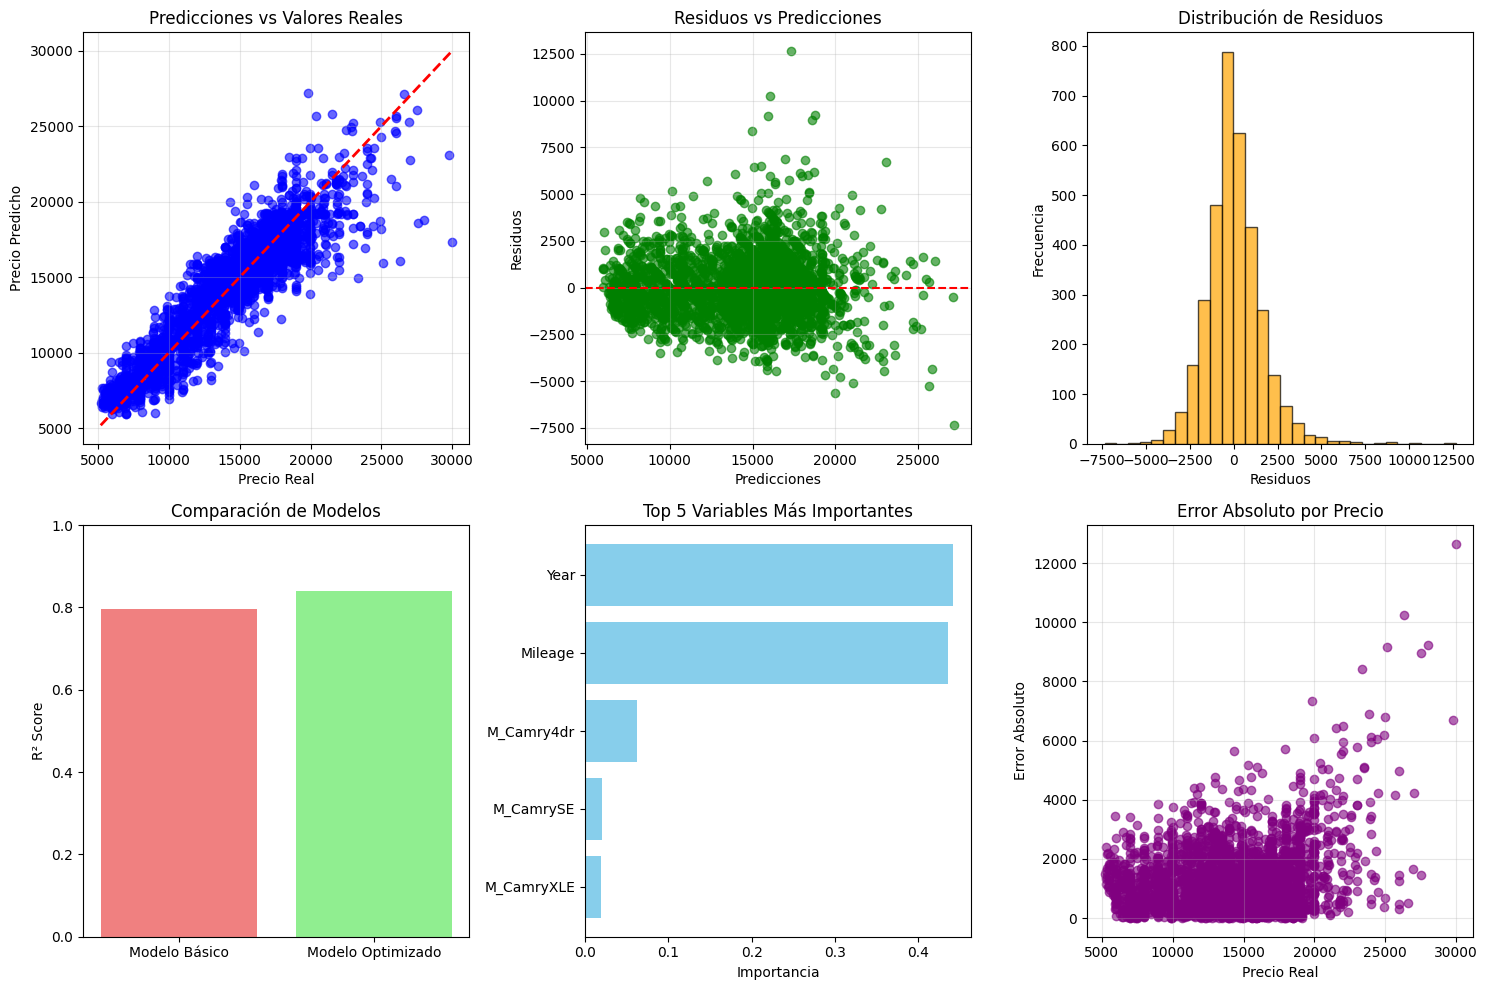


=== CONCLUSIONES DEL ANÁLISIS ===
🎉 1. DESEMPEÑO DEL MODELO: EXCELENTE
   - El modelo explica el 84.0% de la variabilidad en los precios
   - Error promedio de predicción: $1,564

📈 2. MEJORAS OBTENIDAS:
   - La calibración de parámetros mejoró el R² en +0.044
   - Reducción del error en $201

🎯 3. VARIABLES MÁS IMPORTANTES:
   - Variable principal: Year (0.442)
   - Las top 3 variables explican 94.1% del modelo

🔍 4. ANÁLISIS DE RESIDUOS:
   ⚠️ Los residuos muestran cierta dispersión (posible mejora)

💡 5. RECOMENDACIONES:
   - Random Forest es efectivo para predecir precios de automóviles
   - La calibración de hiperparámetros mejora significativamente el rendimiento
   - El modelo puede usarse para estimaciones confiables de precios

🏁 CONCLUSIÓN FINAL:
El modelo Random Forest optimizado logra un desempeño excelente con R²=0.840
y un error promedio de $1,564, siendo útil para la predicción de precios de automóviles.


In [ ]:
#celda 3

print("=== ANÁLISIS FINAL DE RESULTADOS ===")

# Métricas finales del mejor modelo
r2_final = r2_score(y_test, y_pred_mejorado)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_mejorado))
mae_final = mean_absolute_error(y_test, y_pred_mejorado)

print(f"DESEMPEÑO DEL MODELO FINAL:")
print(f"• R² Score: {r2_final:.3f} ({r2_final*100:.1f}% de variabilidad explicada)")
print(f"• RMSE: ${rmse_final:,.0f} (error promedio)")
print(f"• MAE: ${mae_final:,.0f} (error absoluto medio)")

# Gráficos de análisis de residuos
residuos = y_test - y_pred_mejorado

plt.figure(figsize=(15, 10))

# Gráfico 1: Predicciones vs Valores Reales
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_mejorado, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)

# Gráfico 2: Residuos vs Predicciones
plt.subplot(2, 3, 2)
plt.scatter(y_pred_mejorado, residuos, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')
plt.grid(True, alpha=0.3)

# Gráfico 3: Distribución de residuos
plt.subplot(2, 3, 3)
plt.hist(residuos, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')

# Gráfico 4: Comparación de modelos
plt.subplot(2, 3, 4)
modelos = ['Modelo Básico', 'Modelo Optimizado']
r2_scores = [r2_test, r2_final]
plt.bar(modelos, r2_scores, color=['lightcoral', 'lightgreen'])
plt.ylabel('R² Score')
plt.title('Comparación de Modelos')
plt.ylim(0, 1)

# Gráfico 5: Importancia de variables (Top 5)
plt.subplot(2, 3, 5)
top_5 = tabla_importancia.head(5)
plt.barh(top_5['Variable'], top_5['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Top 5 Variables Más Importantes')
plt.gca().invert_yaxis()

# Gráfico 6: Errores por rangos de precio
plt.subplot(2, 3, 6)
plt.scatter(y_test, abs(residuos), alpha=0.6, color='purple')
plt.xlabel('Precio Real')
plt.ylabel('Error Absoluto')
plt.title('Error Absoluto por Precio')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== CONCLUSIONES DEL ANÁLISIS ===")

# Evaluación del desempeño
if r2_final >= 0.8:
    desempeño = "EXCELENTE"
    emoji = "🎉"
elif r2_final >= 0.7:
    desempeño = "BUENO"
    emoji = "✅"
elif r2_final >= 0.6:
    desempeño = "ACEPTABLE"
    emoji = "👍"
else:
    desempeño = "NECESITA MEJORAS"
    emoji = "⚠️"

print(f"{emoji} 1. DESEMPEÑO DEL MODELO: {desempeño}")
print(f"   - El modelo explica el {r2_final*100:.1f}% de la variabilidad en los precios")
print(f"   - Error promedio de predicción: ${rmse_final:,.0f}")

print(f"\n📈 2. MEJORAS OBTENIDAS:")
mejora_total = r2_final - r2_test
print(f"   - La calibración de parámetros mejoró el R² en +{mejora_total:.3f}")
print(f"   - Reducción del error en ${rmse_test - rmse_final:,.0f}")

print(f"\n🎯 3. VARIABLES MÁS IMPORTANTES:")
print(f"   - Variable principal: {tabla_importancia.iloc[0]['Variable']} ({tabla_importancia.iloc[0]['Importancia']:.3f})")
print(f"   - Las top 3 variables explican {tabla_importancia.iloc[:3]['Importancia'].sum():.1%} del modelo")

print(f"\n🔍 4. ANÁLISIS DE RESIDUOS:")
residuos_std = np.std(residuos)
if residuos_std < rmse_final * 0.8:
    print("   ✅ Los residuos muestran un patrón normal (buen ajuste)")
else:
    print("   ⚠️ Los residuos muestran cierta dispersión (posible mejora)")

print(f"\n💡 5. RECOMENDACIONES:")
print("   - Random Forest es efectivo para predecir precios de automóviles")
print("   - La calibración de hiperparámetros mejora significativamente el rendimiento")
print("   - El modelo puede usarse para estimaciones confiables de precios")

if r2_final < 0.8:
    print("   - Para mejores resultados, considerar más variables o técnicas avanzadas")

print(f"\n🏁 CONCLUSIÓN FINAL:")
print(f"El modelo Random Forest optimizado logra un desempeño {desempeño.lower()} con R²={r2_final:.3f}")
print(f"y un error promedio de ${rmse_final:,.0f}, siendo útil para la predicción de precios de automóviles.")

NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.

# Cesar Andres Garces Suarez
## 26/10/2025
## Parcial final
